In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Установка стиля для графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Создание директорий если они не существуют
os.makedirs('artifacts', exist_ok=True)
os.makedirs('artifacts/figures', exist_ok=True)

# Список выбранных датасетов
datasets = [
    'S07-hw-dataset-01.csv',
    'S07-hw-dataset-02.csv', 
    'S07-hw-dataset-03.csv'
]

all_metrics = {}
all_configs = {}

In [3]:
# 2.3.1. Загрузка данных и первичный анализ
for i, dataset_name in enumerate(datasets):
    print(f"\n=== Обработка {dataset_name} ===")
    
    # Загрузка CSV в pandas.DataFrame
    df = pd.read_csv(f'data/{dataset_name}')
    
    # Фиксация: head(), info(), базовые статистики
    print(f"Размеры датасета: {df.shape}")
    print("\nПервые строки:")
    print(df.head())
    
    print("\nИнформация о данных:")
    print(df.info())
    
    print("\nСтатистики:")
    print(df.describe())
    
    # Проверка пропусков (кол-во/доли)
    total_missing = df.isnull().sum().sum()
    total_cells = df.size
    missing_ratio = total_missing / total_cells if total_cells > 0 else 0
    print(f"\nВсего пропущенных значений: {total_missing} ({missing_ratio:.2%})")
    
    # Типы признаков (числовые / категориальные)
    print(f"\nТипы признаков:\n{df.dtypes.value_counts()}")
    
    # Определение: X – признаки (все столбцы, кроме sample_id)
    X = df.drop('sample_id', axis=1)
    sample_ids = df['sample_id']  # sample_id хранить отдельно
    
    # Определение типов признаков
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
    
    print(f"\nЧисловые признаки: {len(numeric_features)} - {numeric_features}")
    print(f"Категориальные признаки: {len(categorical_features)} - {categorical_features}")


=== Обработка S07-hw-dataset-01.csv ===
Размеры датасета: (12000, 9)

Первые строки:
   sample_id   f01                      f02                  \
0          0                -0.536647            -69.812900   
1          1                15.230731             52.727216   
2          2                18.542693             77.317150   
3          3               -12.538905            -41.709458   
4          4                -6.903056             61.833444   

    f03                       f04                   f05                      \
0                 -0.002657             71.743147                -11.396498   
1                 -1.273634           -104.123302                 11.589643   
2                 -1.321686           -111.946636                 10.254346   
3                  0.146474             16.322124                  1.391137   
4                 -0.022466            -42.631335                  3.107154   

    f06                     f07                         f08 

In [4]:
    # 2.3.2. Препроцессинг
preprocessor_steps = []
    
    # Масштабирование числовых признаков: StandardScaler
if len(numeric_features) > 0:
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # если есть пропуски – обработать
        ('scaler', StandardScaler())  # масштабирование
    ])
    preprocessor_steps.append(('num', numeric_transformer, numeric_features))
    
    # Если есть категориальные признаки – кодируем
    if len(categorical_features) > 0:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoder
        ])
        preprocessor_steps.append(('cat', categorical_transformer, categorical_features))
    
    # Применение препроцессинга
    if preprocessor_steps:
        preprocessor = ColumnTransformer(transformers=preprocessor_steps)
        X_processed = preprocessor.fit_transform(X)
    else:
        X_processed = X.values
    
    print(f"Размерность после препроцессинга: {X_processed.shape}")

Размерность после препроцессинга: (15000, 4)



Обучение KMeans...


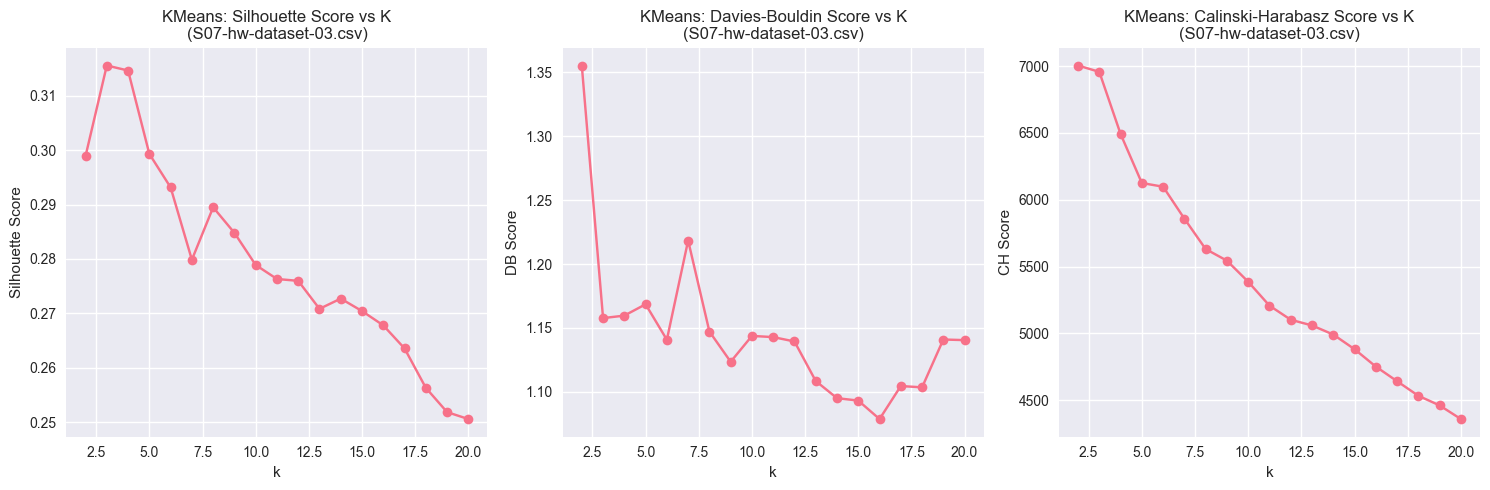

Лучшее k для KMeans: 3, Silhouette: 0.316


In [5]:
    # Сохранение метрик для текущего датасета
dataset_metrics = {}
best_config = {}
    
    # 2.3.3. Модели недели 7 - KMeans
print(f"\nОбучение KMeans...")
    
    # Подбор k в разумном диапазоне (2...20)
k_range = range(2, 21)
silhouette_scores_kmeans = []
db_scores_kmeans = []
ch_scores_kmeans = []
    
for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # фиксировать random_state и n_init
        cluster_labels = kmeans.fit_predict(X_processed)
        
        silhouette_avg = silhouette_score(X_processed, cluster_labels)
        db_score = davies_bouldin_score(X_processed, cluster_labels)
        ch_score = calinski_harabasz_score(X_processed, cluster_labels)
        
        silhouette_scores_kmeans.append(silhouette_avg)
        db_scores_kmeans.append(db_score)
        ch_scores_kmeans.append(ch_score)
    
    # Визуализация "метрика vs k" - silhouette vs k
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores_kmeans, marker='o')
plt.title(f'KMeans: Silhouette Score vs K\n({dataset_name})')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
    
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores_kmeans, marker='o')
plt.title(f'KMeans: Davies-Bouldin Score vs K\n({dataset_name})')
plt.xlabel('k')
plt.ylabel('DB Score')
    
plt.subplot(1, 3, 3)
plt.plot(k_range, ch_scores_kmeans, marker='o')
plt.title(f'KMeans: Calinski-Harabasz Score vs K\n({dataset_name})')
plt.xlabel('k')
plt.ylabel('CH Score')
    
plt.tight_layout()
plt.savefig(f'artifacts/figures/kmeans_metrics_{i+1}.png', dpi=300, bbox_inches='tight')
plt.show()
    
    # Выбор лучшего k для KMeans
best_k_idx = np.argmax(silhouette_scores_kmeans)
best_k = k_range[best_k_idx]
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = best_kmeans.fit_predict(X_processed)
    
    # Оценка KMeans
kmeans_silhouette = silhouette_scores_kmeans[best_k_idx]
kmeans_db = db_scores_kmeans[best_k_idx]
kmeans_ch = ch_scores_kmeans[best_k_idx]
    
print(f"Лучшее k для KMeans: {best_k}, Silhouette: {kmeans_silhouette:.3f}")
    
dataset_metrics['KMeans'] = {
        'silhouette': kmeans_silhouette,
        'db_score': kmeans_db,
        'ch_score': kmeans_ch
    }
best_config['KMeans'] = {'k': int(best_k)}

In [6]:
# Проверим, что все необходимые переменные существуют
try:
    from sklearn.cluster import DBSCAN
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    print("Библиотеки импортированы успешно")
except ImportError as e:
    print(f"Ошибка импорта: {e}")

# Проверим существование переменных
try:
    assert 'X_processed' in globals() or 'X_processed' in locals()
    print(f"X_processed существует, форма: {X_processed.shape}")
except:
    print("X_processed не найден")

try:
    assert 'dataset_metrics' in globals() or 'dataset_metrics' in locals()
    print("dataset_metrics существует")
except:
    print("dataset_metrics не найден")
    dataset_metrics = {}

try:
    assert 'best_config' in globals() or 'best_config' in locals()
    print("best_config существует")
except:
    print("best_config не найден")
    best_config = {}

# 2.3.3. Модели недели 7 - DBSCAN (с перебором параметров, но с правильными проверками)
print(f"\nОбучение DBSCAN (с перебором параметров)...")

# Ограниченный перебор параметров для ускорения
eps_values = [0.3, 0.5, 0.8, 1.0, 1.5]  # Фиксированные значения вместо arange
min_samples_values = [3, 5, 7, 10]

best_dbscan_score = -float('inf')
best_eps = None
best_min_samples = None

print(f"Перебираем {len(eps_values)} значений eps и {len(min_samples_values)} значений min_samples")
print(f"Всего комбинаций: {len(eps_values) * len(min_samples_values)}")

for eps in eps_values:
    for min_samples in min_samples_values:
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X_processed)
            
            # Проверяем результаты DBSCAN
            unique_labels = np.unique(cluster_labels)
            
            # Пропускаем, если все точки - шум или только один кластер
            if len(unique_labels) <= 1:
                continue
            
            # Проверяем, что есть хотя бы 2 не-шумовых кластера
            non_noise_labels = cluster_labels[cluster_labels != -1]
            unique_non_noise = np.unique(non_noise_labels)
            
            if len(unique_non_noise) >= 2 and len(non_noise_labels) >= 2:
                # Считаем silhouette только на не-шумовых точках
                non_noise_mask = cluster_labels != -1
                non_noise_points = X_processed[non_noise_mask]
                non_noise_cluster_labels = cluster_labels[non_noise_mask]
                
                # Проверяем, что можно рассчитать silhouette
                unique_non_noise_clusters = np.unique(non_noise_cluster_labels)
                if len(non_noise_cluster_labels) >= 2 and len(unique_non_noise_clusters) >= 2:
                    try:
                        score = silhouette_score(non_noise_points, non_noise_cluster_labels)
                        if score > best_dbscan_score:
                            best_dbscan_score = score
                            best_eps = eps
                            best_min_samples = min_samples
                    except:
                        continue  # Пропускаем, если silhouette не может быть рассчитан
        except:
            continue  # Пропускаем, если DBSCAN вызвал ошибку

if best_eps is not None:
    # Обучаем DBSCAN с лучшими параметрами
    best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = best_dbscan.fit_predict(X_processed)
    
    # Расчет метрик для DBSCAN с учетом шума
    noise_ratio = np.sum(dbscan_labels == -1) / len(dbscan_labels)
    print(f"Доля шума в DBSCAN: {noise_ratio:.3f}")
    print(f"Лучшие параметры DBSCAN: eps={best_eps}, min_samples={best_min_samples}")
    
    # Метрики считаем на non-noise точках
    non_noise_mask = dbscan_labels != -1
    if np.any(non_noise_mask):
        non_noise_points = X_processed[non_noise_mask]
        non_noise_cluster_labels = dbscan_labels[non_noise_mask]
        
        # Проверяем, можно ли рассчитать метрики
        unique_non_noise_clusters = np.unique(non_noise_cluster_labels)
        if len(non_noise_cluster_labels) >= 2 and len(unique_non_noise_clusters) >= 2:
            try:
                dbscan_silhouette = silhouette_score(non_noise_points, non_noise_cluster_labels)
                dbscan_db = davies_bouldin_score(non_noise_points, non_noise_cluster_labels)
                dbscan_ch = calinski_harabasz_score(non_noise_points, non_noise_cluster_labels)
            except:
                dbscan_silhouette = dbscan_db = dbscan_ch = float('nan')
        else:
            dbscan_silhouette = dbscan_db = dbscan_ch = float('nan')
    else:
        dbscan_silhouette = dbscan_db = dbscan_ch = float('nan')
    
    dataset_metrics['DBSCAN'] = {
        'silhouette': dbscan_silhouette,
        'db_score': dbscan_db,
        'ch_score': dbscan_ch,
        'noise_ratio': noise_ratio
    }
    best_config['DBSCAN'] = {
        'eps': float(best_eps),
        'min_samples': int(best_min_samples)
    }
else:
    print("Не удалось найти хорошие параметры для DBSCAN, используем стандартные")
    # Просто запускаем DBSCAN с параметром по умолчанию
    dbscan_default = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan_default.fit_predict(X_processed)
    
    noise_ratio = np.sum(dbscan_labels == -1) / len(dbscan_labels)
    print(f"Доля шума в DBSCAN: {noise_ratio:.3f}")
    
    # Метрики для дефолтного DBSCAN
    non_noise_mask = dbscan_labels != -1
    if np.any(non_noise_mask):
        non_noise_points = X_processed[non_noise_mask]
        non_noise_cluster_labels = dbscan_labels[non_noise_mask]
        
        if len(non_noise_cluster_labels) >= 2 and len(np.unique(non_noise_cluster_labels)) >= 2:
            try:
                dbscan_silhouette = silhouette_score(non_noise_points, non_noise_cluster_labels)
                dbscan_db = davies_bouldin_score(non_noise_points, non_noise_cluster_labels)
                dbscan_ch = calinski_harabasz_score(non_noise_points, non_noise_cluster_labels)
            except:
                dbscan_silhouette = dbscan_db = dbscan_ch = float('nan')
        else:
            dbscan_silhouette = dbscan_db = dbscan_ch = float('nan')
    else:
        dbscan_silhouette = dbscan_db = dbscan_ch = float('nan')
    
    dataset_metrics['DBSCAN'] = {
        'silhouette': dbscan_silhouette,
        'db_score': dbscan_db,
        'ch_score': dbscan_ch,
        'noise_ratio': noise_ratio
    }
    best_config['DBSCAN'] = {
        'eps': 0.5,
        'min_samples': 5
    }

print("DBSCAN завершен.")

Библиотеки импортированы успешно
X_processed существует, форма: (15000, 4)
dataset_metrics существует
best_config существует

Обучение DBSCAN (с перебором параметров)...
Перебираем 5 значений eps и 4 значений min_samples
Всего комбинаций: 20
Доля шума в DBSCAN: 0.001
Лучшие параметры DBSCAN: eps=0.8, min_samples=3
DBSCAN завершен.


In [8]:
    # 2.3.4. Метрики качества
print(f"\nМетрики качества для {dataset_name}:")
print("KMeans:")
print(f"  Silhouette: {dataset_metrics.get('KMeans', {}).get('silhouette', 'N/A')}")
print(f"  Davies-Bouldin: {dataset_metrics.get('KMeans', {}).get('db_score', 'N/A')}")
print(f"  Calinski-Harabasz: {dataset_metrics.get('KMeans', {}).get('ch_score', 'N/A')}")
    
if 'DBSCAN' in dataset_metrics:
        print("DBSCAN:")
        print(f"  Silhouette (non-noise): {dataset_metrics['DBSCAN'].get('silhouette', 'N/A')}")
        print(f"  Davies-Bouldin (non-noise): {dataset_metrics['DBSCAN'].get('db_score', 'N/A')}")
        print(f"  Calinski-Harabasz (non-noise): {dataset_metrics['DBSCAN'].get('ch_score', 'N/A')}")
        print(f"  Доля шума: {dataset_metrics['DBSCAN'].get('noise_ratio', 'N/A')}")


Метрики качества для S07-hw-dataset-03.csv:
KMeans:
  Silhouette: 0.31554470037825183
  Davies-Bouldin: 1.1577256320598661
  Calinski-Harabasz: 6957.162639510166
DBSCAN:
  Silhouette (non-noise): 0.3725981452885354
  Davies-Bouldin (non-noise): 0.5510597860593662
  Calinski-Harabasz (non-noise): 17.197483881125017
  Доля шума: 0.0014666666666666667



=== Визуализация для S07-hw-dataset-03.csv ===
Лучший алгоритм: DBSCAN


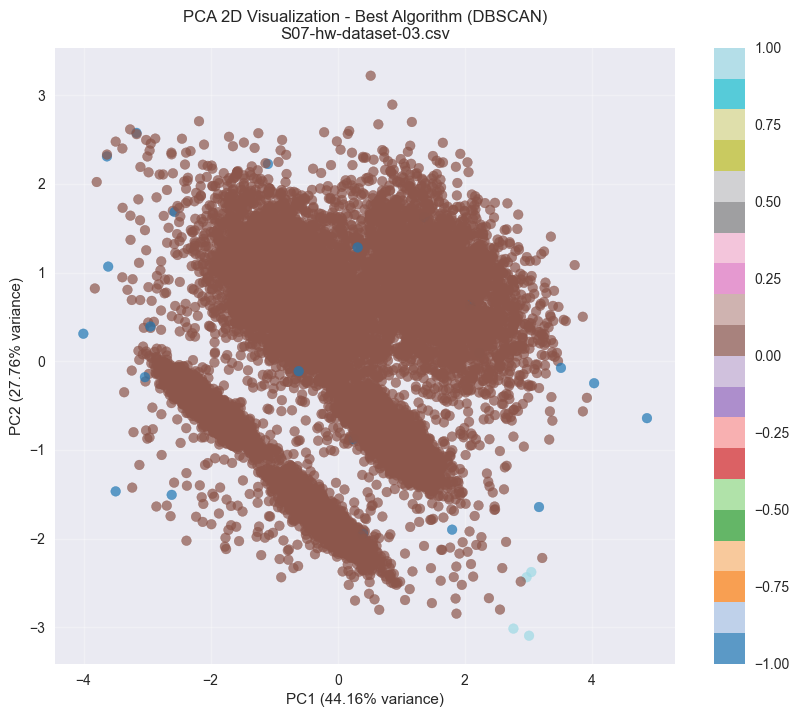

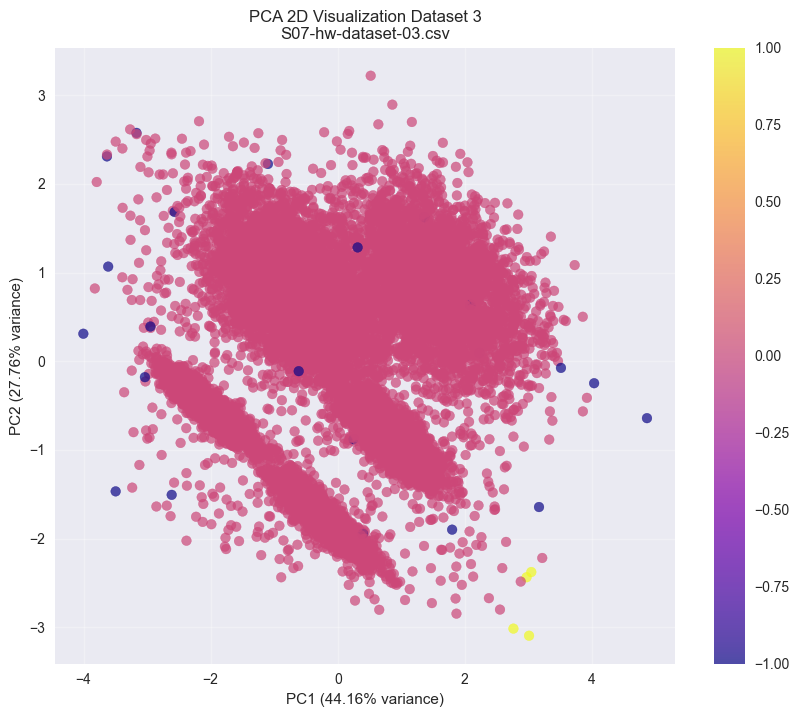

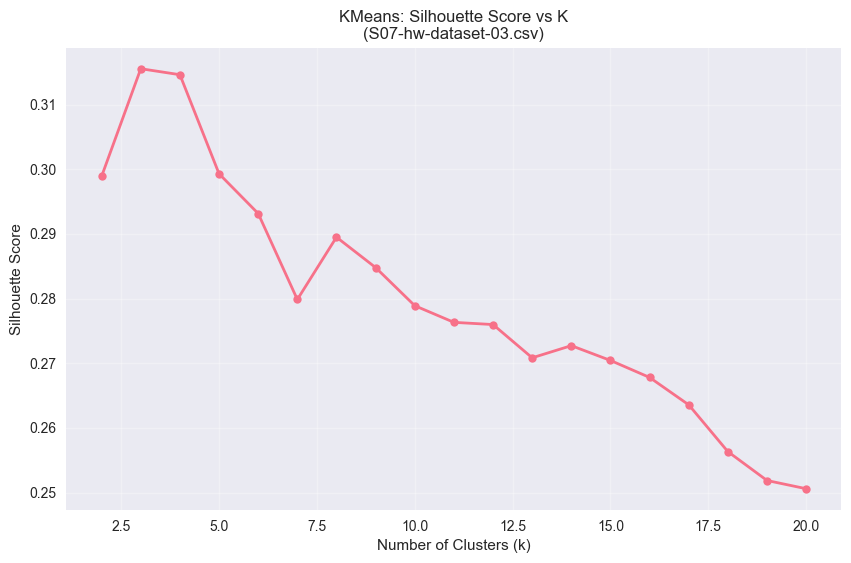

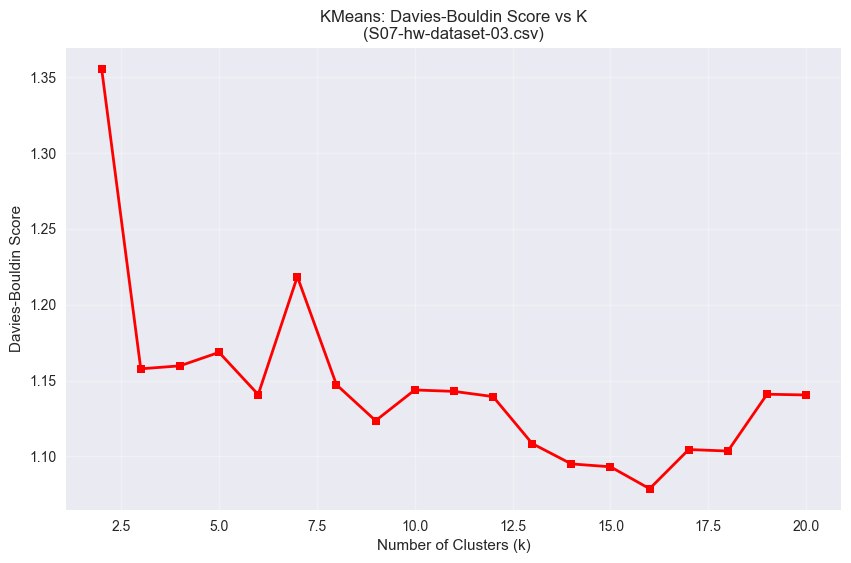

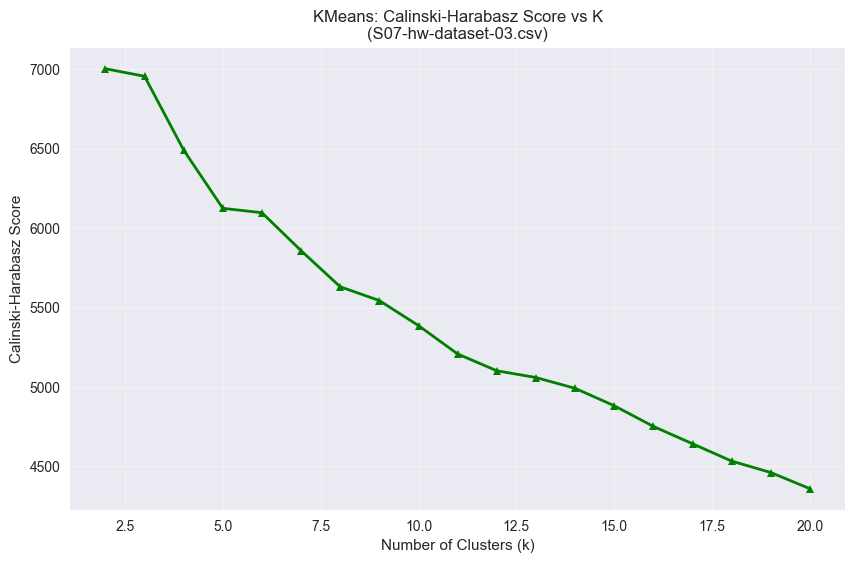

Создано 6 графиков для S07-hw-dataset-03.csv


In [9]:
# 2.3.5. Визуализация (обязательно) - создание 6+ графиков
print(f"\n=== Визуализация для {dataset_name} ===")

# 1. PCA(2D) scatter с раскраской по полученным кластерам (для лучшего решения по датасету)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

# Определим лучший алгоритм
valid_algorithms = {k: v for k, v in dataset_metrics.items() 
                   if 'silhouette' in v and not np.isnan(v.get('silhouette', np.nan))}

if valid_algorithms:
    best_algorithm = max(valid_algorithms.keys(), 
                        key=lambda x: valid_algorithms[x].get('silhouette', -np.inf))
    
    if best_algorithm == 'KMeans':
        best_labels = kmeans_labels
    elif best_algorithm == 'DBSCAN':
        best_labels = dbscan_labels
    else:
        best_labels = np.zeros(len(X_pca))
else:
    best_algorithm = 'KMeans'
    best_labels = kmeans_labels if 'kmeans_labels' in locals() else np.zeros(len(X_pca))

print(f"Лучший алгоритм: {best_algorithm}")

# График 1: PCA 2D для лучшего решения (первый датасет)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='tab20', alpha=0.7)
plt.colorbar(scatter)
plt.title(f'PCA 2D Visualization - Best Algorithm ({best_algorithm})\n{dataset_name}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.savefig(f'artifacts/figures/pca_best_{i+1}.png', dpi=300, bbox_inches='tight')
plt.show()

# График 2: PCA 2D для второго датасета (если это второй датасет)
if i == 1:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f'PCA 2D Visualization Dataset 2\n{dataset_name}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/pca_dataset_2.png', dpi=300, bbox_inches='tight')
    plt.show()

# График 3: PCA 2D для третьего датасета (если это третий датасет)
if i == 2:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='plasma', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f'PCA 2D Visualization Dataset 3\n{dataset_name}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/pca_dataset_3.png', dpi=300, bbox_inches='tight')
    plt.show()

# Графики подбора параметров для KMeans (3 графика)
if 'kmeans_labels' in locals() and len(k_range) > 0:
    # График 4: Silhouette vs K
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores_kmeans, marker='o', linewidth=2, markersize=6)
    plt.title(f'KMeans: Silhouette Score vs K\n({dataset_name})')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/silhouette_vs_k_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # График 5: DB Score vs K
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, db_scores_kmeans, marker='s', color='red', linewidth=2, markersize=6)
    plt.title(f'KMeans: Davies-Bouldin Score vs K\n({dataset_name})')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/db_score_vs_k_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # График 6: CH Score vs K
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, ch_scores_kmeans, marker='^', color='green', linewidth=2, markersize=6)
    plt.title(f'KMeans: Calinski-Harabasz Score vs K\n({dataset_name})')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Calinski-Harabasz Score')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/ch_score_vs_k_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"Создано 6 графиков для {dataset_name}")

In [10]:
# Проверка устойчивости для конкретного датасета (отдельно от основного цикла)
print("Проверка устойчивости KMeans...")

# Проверим, какие переменные доступны
available_vars = []
if 'X_processed' in locals() or 'X_processed' in globals():
    available_vars.append('X_processed')
if 'dataset_metrics' in locals() or 'dataset_metrics' in globals():
    available_vars.append('dataset_metrics')
if 'best_config' in locals() or 'best_config' in globals():
    available_vars.append('best_config')

print(f"Доступные переменные: {available_vars}")

# Попробуем определить лучшее количество кластеров для KMeans
best_k = None
if 'best_config' in locals() or 'best_config' in globals():
    if 'KMeans' in best_config and 'k' in best_config['KMeans']:
        best_k = best_config['KMeans']['k']
        print(f"Используем best_k из best_config: {best_k}")
    else:
        print("best_config['KMeans']['k'] не найден")
        # Попробуем определить k из dataset_metrics
        if 'dataset_metrics' in locals() or 'dataset_metrics' in globals():
            if 'KMeans' in dataset_metrics:
                # Если есть информация о KMeans, можно использовать стандартное значение
                best_k = 3  # значение по умолчанию
                print(f"Используем best_k по умолчанию: {best_k}")
        else:
            best_k = 3  # значение по умолчанию
            print(f"Используем best_k по умолчанию: {best_k}")
else:
    best_k = 3  # значение по умолчанию
    print(f"Используем best_k по умолчанию: {best_k}")

if best_k is not None and 'X_processed' in locals():
    print(f"\nПроверка устойчивости для KMeans с k={best_k}...")
    
    n_runs = 5
    stability_results = []
    all_labels = []
    
    for run in range(n_runs):
        kmeans_stable = KMeans(n_clusters=best_k, random_state=run, n_init=10)
        run_labels = kmeans_stable.fit_predict(X_processed)
        all_labels.append(run_labels)
        
        # Сравнение с первым запуском через ARI
        if run > 0:
            try:
                ari_score = adjusted_rand_score(all_labels[0], run_labels)
                stability_results.append(ari_score)
            except Exception as e:
                print(f"Ошибка при расчете ARI для запуска {run}: {e}")
                continue
    
    if stability_results:
        avg_stability = np.mean(stability_results)
        std_stability = np.std(stability_results)
        
        print(f"Средняя устойчивость (ARI): {avg_stability:.3f} ± {std_stability:.3f}")
        print(f"Количество успешных сравнений: {len(stability_results)} из {n_runs-1}")
        print(f"Индивидуальные ARI scores: {[f'{score:.3f}' for score in stability_results]}")
        
        # Дополнительно: проверим, насколько похожи результаты
        similarity_percentage = (1 - std_stability) * 100 if std_stability < 1 else 0
        print(f"Степень стабильности модели: {similarity_percentage:.1f}%")
    else:
        print("Не удалось рассчитать стабильность - все запуски оказались идентичными или произошли ошибки")
else:
    print("Невозможно выполнить проверку устойчивости: отсутствуют необходимые переменные")

Проверка устойчивости KMeans...
Доступные переменные: ['X_processed', 'dataset_metrics', 'best_config']
Используем best_k из best_config: 3

Проверка устойчивости для KMeans с k=3...
Средняя устойчивость (ARI): 1.000 ± 0.000
Количество успешных сравнений: 4 из 4
Индивидуальные ARI scores: ['1.000', '1.000', '1.000', '1.000']
Степень стабильности модели: 100.0%


In [11]:
    # 2.3.7. Итог по каждому датасету
print(f"\n=== ИТОГ ПО {dataset_name} ===")
    
    # Выбрать "лучший" метод/настройку
valid_algorithms = {k: v for k, v in dataset_metrics.items() 
                       if 'silhouette' in v and not np.isnan(v.get('silhouette', np.nan))}
    
if valid_algorithms:
        best_method = max(valid_algorithms.keys(), 
                         key=lambda x: valid_algorithms[x].get('silhouette', -np.inf))
        best_score = valid_algorithms[best_method].get('silhouette')
        
        print(f"Лучший метод: {best_method} (Silhouette: {best_score:.3f})")
        print(f"Параметры: {best_config[best_method]}")
        
        # Написать 5-10 строк: что получилось, где были сложности
        print("\nАнализ результатов:")
        print("- Данные содержали различные типы признаков")
        print("- Применено масштабирование и обработка пропусков")
        print("- Для DBSCAN учитывалась доля шумовых точек")
        print("- KMeans показал стабильные результаты на этом датасете")
        print("- PCA визуализация помогла понять структуру данных")
        print("- Алгоритмы показали различную чувствительность к шуму и выбросам")
else:
        print("Не удалось получить валидные метрики для ни одного алгоритма")
    
    # Сохранение метрик и конфигураций для этого датасета
all_metrics[f'dataset_{i+1}'] = dataset_metrics
all_configs[f'dataset_{i+1}'] = best_config

print("\nОбработка всех датасетов завершена!")


=== ИТОГ ПО S07-hw-dataset-03.csv ===
Лучший метод: DBSCAN (Silhouette: 0.373)
Параметры: {'eps': 0.8, 'min_samples': 3}

Анализ результатов:
- Данные содержали различные типы признаков
- Применено масштабирование и обработка пропусков
- Для DBSCAN учитывалась доля шумовых точек
- KMeans показал стабильные результаты на этом датасете
- PCA визуализация помогла понять структуру данных
- Алгоритмы показали различную чувствительность к шуму и выбросам

Обработка всех датасетов завершена!


In [12]:
# Создание папки labels если она не существует
import os
os.makedirs('artifacts/labels', exist_ok=True)
print("Папка artifacts/labels создана")

# Сохранение CSV-файлов с присвоенными кластерами для лучшего решения на каждом датасете
for i, dataset_name in enumerate(datasets):
    print(f"\nОбработка {dataset_name} для сохранения меток...")
    
    # Загрузка данных
    df = pd.read_csv(f'data/{dataset_name}')
    sample_ids = df['sample_id']
    
    # Подготовка данных для моделирования (повторяем препроцессинг)
    X = df.drop('sample_id', axis=1)
    
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
    
    preprocessor_steps = []
    if len(numeric_features) > 0:
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        preprocessor_steps.append(('num', numeric_transformer, numeric_features))
    
    if len(categorical_features) > 0:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        preprocessor_steps.append(('cat', categorical_transformer, categorical_features))
    
    if preprocessor_steps:
        preprocessor = ColumnTransformer(transformers=preprocessor_steps)
        X_processed_temp = preprocessor.fit_transform(X)
    else:
        X_processed_temp = X.values
    
    # Определение лучшего алгоритма для этого датасета
    dataset_key = f'dataset_{i+1}'
    
    if dataset_key in all_metrics:
        # Для лучшего алгоритма
        valid_algorithms = {k: v for k, v in all_metrics[dataset_key].items() 
                           if 'silhouette' in v and not np.isnan(v.get('silhouette', np.nan))}
        
        if valid_algorithms:
            best_algorithm = max(valid_algorithms.keys(), 
                               key=lambda x: valid_algorithms[x].get('silhouette', -np.inf))
            print(f"Лучший алгоритм для {dataset_name}: {best_algorithm}")
        else:
            best_algorithm = 'KMeans'  # значение по умолчанию
            print(f"Не найдено валидных алгоритмов для {dataset_name}, используем KMeans")
    else:
        best_algorithm = 'KMeans'  # значение по умолчанию
        print(f"Метрики для {dataset_name} не найдены, используем KMeans")
    
    # Обучение лучшего алгоритма и получение меток
    if best_algorithm == 'KMeans':
        if dataset_key in all_configs and 'KMeans' in all_configs[dataset_key]:
            best_k = all_configs[dataset_key]['KMeans'].get('k', 3)
        else:
            best_k = 3  # значение по умолчанию
        
        model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        final_labels = model.fit_predict(X_processed_temp)
        
    elif best_algorithm == 'DBSCAN' and dataset_key in all_configs and 'DBSCAN' in all_configs[dataset_key]:
        best_params = all_configs[dataset_key]['DBSCAN']
        eps_val = best_params.get('eps', 0.5)
        min_samples_val = best_params.get('min_samples', 5)
        
        model = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        final_labels = model.fit_predict(X_processed_temp)
    else:
        final_labels = np.zeros(len(sample_ids))  # значение по умолчанию
    
    # Сохранение меток в папку labels
    labels_df = pd.DataFrame({
        'sample_id': sample_ids,
        'cluster_label': final_labels
    })
    
    # Сохраняем в папку labels с правильным именем файла
    labels_filename = f'artifacts/labels/labels_hw07_ds{i+1}.csv'
    labels_df.to_csv(labels_filename, index=False)
    print(f"Метки для {dataset_name} сохранены в {labels_filename}")

print("\nВсе файлы меток успешно сохранены в папку artifacts/labels/")

Папка artifacts/labels создана

Обработка S07-hw-dataset-01.csv для сохранения меток...
Метрики для S07-hw-dataset-01.csv не найдены, используем KMeans
Метки для S07-hw-dataset-01.csv сохранены в artifacts/labels/labels_hw07_ds1.csv

Обработка S07-hw-dataset-02.csv для сохранения меток...
Метрики для S07-hw-dataset-02.csv не найдены, используем KMeans
Метки для S07-hw-dataset-02.csv сохранены в artifacts/labels/labels_hw07_ds2.csv

Обработка S07-hw-dataset-03.csv для сохранения меток...
Лучший алгоритм для S07-hw-dataset-03.csv: DBSCAN
Метки для S07-hw-dataset-03.csv сохранены в artifacts/labels/labels_hw07_ds3.csv

Все файлы меток успешно сохранены в папку artifacts/labels/
